# 04. Generating Sets of Chemicals with the ChemicalMixtureCreator class

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

In [9]:
import os
import sys
sys.path.append('../..')

In [19]:
import pylab as plt
%matplotlib inline

In [4]:
from vimms.Chemicals import ChemicalMixtureCreator

## Introduction

The `ChemicalMixtureCreator` offers the most simple method for creating chemical datasets for simulation allowing the generation of a dataset of chemicals in just a few lines of python.

The class requires several other classes to run:

- A class that can generate _formulas_
- A class that can generate RT and intensity for formulas
- A class that can generate chromatograms for formulas
- A class that can generate MS2 spectra for formulas

### `FormulaSampler`

An instance of a class extending `FormulaSampler` must be provided. This samples the chemicals that will appear. Note that `Formula` is abused here: in some cases the result is a chemical formula, but in others, just an m/z. Which it does has implications for the data generated (see below).  Currently, the following options are available:

- `DatabaseFormulaSampler`: samples formulas from a database provided. Code is given to generate from HMDB
- `UniformMZFormulaSampler`: samples _formulas_ (just masses) uniformly in an m/z range
- `PickEverythingFormulaSampler`: samples all formulas from a database
- `EvenMZFormulaSampler`: creates evenly spaced m/z, starting at 100Da, with 100 Da spacing. Mainly used for test cases.
- `MZMLFormulaSampler`: samples m/z values from a histogram of m/z taken from a user supplied mzML file

Examples of creating some of these objects

#### `DatabaseFormulaSampler`

In [7]:
from vimms.ChemicalSamplers import DatabaseFormulaSampler
from vimms.Common import load_obj

In [11]:
data_dir = os.path.abspath(os.path.join(os.getcwd(),'..','..','tests','fixtures'))
HMDB = os.path.join(data_dir,'hmdb_compounds.p')
hmdb = load_obj(HMDB)

In [ ]:
# create a database formula sampler that will sample from HMDB with m/z between 100 and 1000
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

(array([ 95.,  95.,  94.,  95., 108., 105.,  95., 103., 117.,  93.]),
 array([100.18070129, 140.13752696, 180.09435263, 220.0511783 ,
        260.00800397, 299.96482964, 339.92165531, 379.87848098,
        419.83530665, 459.79213232, 499.74895799]),
 <BarContainer object of 10 artists>)

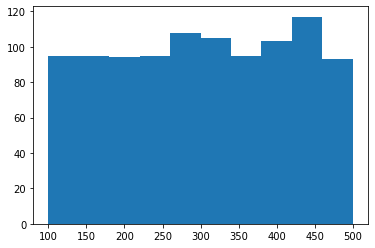

In [21]:
from vimms.ChemicalSamplers import UniformMZFormulaSampler
# create a formula sampler that samples masses uniformly between 100 and 500
df = UniformMZFormulaSampler(min_mz=100, max_mz=500)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

Loaded 364 scans


(array([161., 215., 451., 141.,  19.,   3.,   7.,   1.,   0.,   2.]),
 array([ 82.17358934, 147.7886142 , 213.40363906, 279.01866392,
        344.63368877, 410.24871363, 475.86373849, 541.47876335,
        607.0937882 , 672.70881306, 738.32383792]),
 <BarContainer object of 10 artists>)

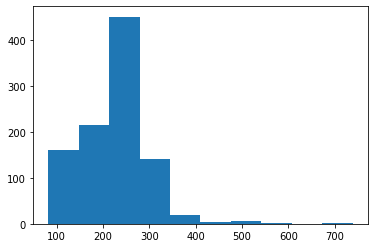

In [23]:
from vimms.ChemicalSamplers import MZMLFormulaSampler
MZML = os.path.join(data_dir, 'small_mzml.mzML')
df = MZMLFormulaSampler(MZML)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

### `RTAndIntensitySampler`

Passing an instance of this is optional. If nothing is passed, it defaults to `UniformRTAndIntensitySampler`

Available:

- `UniformRTAndIntensitySampler`: samples RT and intensity independently from uniform distributions (note that intensity is unifrom in log space)
- `MZMLRTandIntensitySampler`: samples RT and intensity independely from histograms produced from an mzML file

Examples:

#### `UniformRTAndIntensitySampler`

(array([665., 100.,  60.,  46.,  30.,  28.,  28.,  18.,  12.,  13.]),
 array([7.48074741e+00, 8.14084684e+02, 1.62068862e+03, 2.42729256e+03,
        3.23389649e+03, 4.04050043e+03, 4.84710437e+03, 5.65370831e+03,
        6.46031224e+03, 7.26691618e+03, 8.07352012e+03]),
 <BarContainer object of 10 artists>)

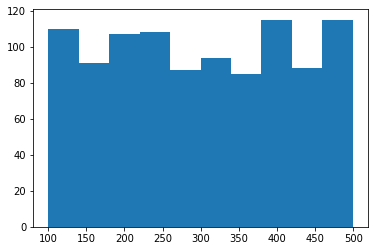

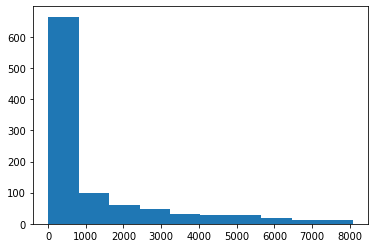

In [28]:
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler
ri = UniformRTAndIntensitySampler(min_rt=100, max_rt=500, min_log_intensity=2, max_log_intensity=9)
rt_list = []
intensity_list = []
for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)
plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)